Lot of work still remains, this was the first submission module which creates a csv file we upload to kaggle for submission.

-> LightGBM LambdaRank + advanced features (percentile rank, delta, CTR, bucketization). Trained on 400k rows, tested on full test set.

-> Enriched model with 28 features (log price, group deltas, CTR, star bucket). Model: LightGBM LambdaRank (early stopping, ndcg@5 avg ≈ 0.407). Chunked test inference.

-> Full test re-ranking using LightGBM LambdaRank with engineered 28-feature pipeline. Expecting ndcg@5 > 0.40.


In [1]:
# 📦 Setup: Mount Google Drive & Install Dependencies
from google.colab import drive
drive.mount('/content/drive')

!pip install -q kaggle pandas numpy matplotlib seaborn

# 📥 Download from Google Drive via gdown
!gdown --id 1znhL6ZFc_m5ozMfDvBj9b80de4a6OSyQ --output dmt_dataset.zip

# 📂 Extract the zip
import zipfile
with zipfile.ZipFile("dmt_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("data")


Mounted at /content/drive
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1znhL6ZFc_m5ozMfDvBj9b80de4a6OSyQ
From (redirected): https://drive.google.com/uc?id=1znhL6ZFc_m5ozMfDvBj9b80de4a6OSyQ&confirm=t&uuid=487836a0-5387-4e59-9b7e-4f9a74ee43f8
To: /content/dmt_dataset.zip
100% 285M/285M [00:05<00:00, 48.4MB/s]


In [2]:
import os

print("🔍 Contents of /data after unzipping:")
for root, dirs, files in os.walk("data"):
    for file in files:
        print(os.path.join(root, file))


🔍 Contents of /data after unzipping:
data/training_set_VU_DM.csv
data/submission_sample.csv
data/test_set_VU_DM.csv


In [3]:
# ✅ Step 1: Create `data/` folder
import os
os.makedirs("data", exist_ok=True)

# ✅ Step 2: Extract the zip
import zipfile

with zipfile.ZipFile("dmt_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

# ✅ Step 3: Load CSVs
import pandas as pd

train_path = "data/training_set_VU_DM.csv"
test_path = "data/test_set_VU_DM.csv"


if os.path.exists(train_path) and os.path.exists(test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    print("✅ Successfully loaded the datasets!")
    print("Train shape:", train.shape)
    print("Test shape :", test.shape)
    display(train.head())
else:
    print("❌ train.csv or test.csv not found in /data")


✅ Successfully loaded the datasets!
Train shape: (4958347, 54)
Test shape : (4959183, 50)


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [4]:
pip install pandas numpy scikit-learn lightgbm xgboost catboost tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00


In [5]:
print("✅ Dataset shape:", train.shape)
print("🧩 Unique searches:", train['srch_id'].nunique())
print("🏨 Unique properties:", train['prop_id'].nunique())
print("📌 Columns with most nulls:\n")
print(train.isnull().sum().sort_values(ascending=False).head(10))


✅ Dataset shape: (4958347, 54)
🧩 Unique searches: 199795
🏨 Unique properties: 129113
📌 Columns with most nulls:

comp1_rate_percent_diff    4863908
comp6_rate_percent_diff    4862173
comp1_rate                 4838417
comp1_inv                  4828788
comp4_rate_percent_diff    4827261
gross_bookings_usd         4819957
comp7_rate_percent_diff    4819832
comp6_rate                 4718190
visitor_hist_starrating    4706481
visitor_hist_adr_usd       4705359
dtype: int64


In [1]:
# import pandas as pd
# import numpy as np

# # === Load Data ===
# train = pd.read_csv("/content/data/training_set_VU_DM.csv")  # replace with actual path
# sample_frac = 0.05  # Adjust based on available memory
# train = train.sample(frac=sample_frac, random_state=42)

# # === Missing Value Handling ===
# missing_features = [
#     'visitor_hist_adr_usd', 'visitor_hist_starrating', 'prop_review_score',
#     'comp1_rate_percent_diff', 'orig_destination_distance'
# ]

# for col in missing_features:
#     train[f'is_null_{col}'] = train[col].isnull().astype(int)

# train['visitor_hist_adr_usd'].fillna(-1, inplace=True)
# train['visitor_hist_starrating'].fillna(-1, inplace=True)
# train['prop_review_score'].fillna(train['prop_review_score'].median(), inplace=True)
# train['orig_destination_distance'].fillna(train['orig_destination_distance'].median(), inplace=True)
# train['comp1_rate_percent_diff'].fillna(-999, inplace=True)

# # === Log Transform Skewed Features ===
# train['price_usd_log'] = np.log1p(train['price_usd'])
# train['distance_log'] = np.log1p(train['orig_destination_distance'])

# # === Outlier Clipping ===
# price_upper = train['price_usd'].quantile(0.995)
# train = train[train['price_usd'] < price_upper]

# # === Group-wise Percentile Ranks ===
# train['price_rank_pct'] = train.groupby('srch_id')['price_usd'].rank(pct=True)
# train['location_score_rank_pct'] = train.groupby('srch_id')['prop_location_score1'].rank(pct=True)
# train['review_score_rank_pct'] = train.groupby('srch_id')['prop_review_score'].rank(pct=True)

# # === Feature Engineering ===
# train['price_vs_hist'] = train['price_usd'] - train['visitor_hist_adr_usd']
# train['star_diff'] = train['prop_starrating'] - train['visitor_hist_starrating']
# train['promo_available_in_group'] = train.groupby('srch_id')['promotion_flag'].transform('sum')

# # === Label Engineering ===
# train['target'] = 5 * train['booking_bool'] + train['click_bool']

# # === Save EDA Output ===
# eda_cols = [
#     'price_usd', 'price_usd_log', 'price_rank_pct', 'location_score_rank_pct',
#     'review_score_rank_pct', 'price_vs_hist', 'star_diff', 'promo_available_in_group',
#     'target'
# ]
# # train[eda_cols].to_csv("eda_sample_output.csv", index=False)
# # print("EDA output saved to eda_sample_output.csv")


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [2]:
import pandas as pd
import numpy as np

# === LOAD SMALL SAMPLE FOR SAFE EDA ===
chunksize = 100_000  # Load in chunks to reduce memory
sample_frac = 0.01   # Further sampling per chunk

chunks = pd.read_csv("/content/data/training_set_VU_DM.csv", chunksize=chunksize)

sampled_data = []
for chunk in chunks:
    sampled_chunk = chunk.sample(frac=sample_frac, random_state=42)
    sampled_data.append(sampled_chunk)

train = pd.concat(sampled_data, ignore_index=True)

# === NULL HANDLING ===
for col in ['visitor_hist_adr_usd', 'visitor_hist_starrating', 'prop_review_score',
            'comp1_rate_percent_diff', 'orig_destination_distance']:
    train[f'is_null_{col}'] = train[col].isnull().astype(int)

train['visitor_hist_adr_usd'].fillna(-1, inplace=True)
train['visitor_hist_starrating'].fillna(-1, inplace=True)
train['prop_review_score'].fillna(train['prop_review_score'].median(), inplace=True)
train['orig_destination_distance'].fillna(train['orig_destination_distance'].median(), inplace=True)
train['comp1_rate_percent_diff'].fillna(-999, inplace=True)

# === SAFE TRANSFORMATIONS ===
train['price_usd_log'] = np.log1p(train['price_usd'])
train['distance_log'] = np.log1p(train['orig_destination_distance'])

# === OUTLIER FILTERING ===
price_upper = train['price_usd'].quantile(0.995)
train = train[train['price_usd'] < price_upper]

# === SAFE RANKING: only on a small subset of srch_id ===
top_search_ids = train['srch_id'].value_counts().head(100).index
train_subset = train[train['srch_id'].isin(top_search_ids)].copy()

for col in ['price_usd', 'prop_location_score1', 'prop_review_score']:
    train_subset[f'{col}_rank_pct'] = train_subset.groupby('srch_id')[col].rank(pct=True)

# === FEATURE ENGINEERING ===
train_subset['price_vs_hist'] = train_subset['price_usd'] - train_subset['visitor_hist_adr_usd']
train_subset['star_diff'] = train_subset['prop_starrating'] - train_subset['visitor_hist_starrating']
train_subset['promo_available_in_group'] = train_subset.groupby('srch_id')['promotion_flag'].transform('sum')
train_subset['target'] = 5 * train_subset['booking_bool'] + train_subset['click_bool']

# === EXPORT RESULT ===
eda_cols = [col for col in train_subset.columns if 'rank_pct' in col or col in [
    'price_usd', 'price_usd_log', 'distance_log', 'price_vs_hist',
    'star_diff', 'promo_available_in_group', 'target'
]]
train_subset[eda_cols].to_csv("eda_sample_output_small.csv", index=False)
print("Sampled EDA output saved to eda_sample_output_small.csv")


Sampled EDA output saved to eda_sample_output_small.csv


<ipython-input-2-0d4c1a9ce34e>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['visitor_hist_adr_usd'].fillna(-1, inplace=True)
<ipython-input-2-0d4c1a9ce34e>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [3]:
import pandas as pd
import numpy as np

def transform_features(df):
    # Null indicators
    for col in ['visitor_hist_adr_usd', 'visitor_hist_starrating', 'prop_review_score',
                'comp1_rate_percent_diff', 'orig_destination_distance']:
        df[f'is_null_{col}'] = df[col].isnull().astype(int)

    df['visitor_hist_adr_usd'] = df['visitor_hist_adr_usd'].fillna(-1)
    df['visitor_hist_starrating'] = df['visitor_hist_starrating'].fillna(-1)
    df['prop_review_score'] = df['prop_review_score'].fillna(df['prop_review_score'].median())
    df['orig_destination_distance'] = df['orig_destination_distance'].fillna(df['orig_destination_distance'].median())
    df['comp1_rate_percent_diff'] = df['comp1_rate_percent_diff'].fillna(-999)

    # Log transforms
    df['price_usd_log'] = np.log1p(df['price_usd'])
    df['distance_log'] = np.log1p(df['orig_destination_distance'])

    # Feature engineering
    df['price_vs_hist'] = df['price_usd'] - df['visitor_hist_adr_usd']
    df['star_diff'] = df['prop_starrating'] - df['visitor_hist_starrating']

    # Label (click/book)
    df['target'] = 5 * df['booking_bool'] + df['click_bool']

    return df

# === CHUNKED PROCESSING ===
input_path = "/content/data/training_set_VU_DM.csv"
output_path = "train_transformed.csv"
chunksize = 500_000
first_chunk = True

reader = pd.read_csv(input_path, chunksize=chunksize)

for chunk in reader:
    transformed = transform_features(chunk)

    # Append to CSV
    if first_chunk:
        transformed.to_csv(output_path, index=False, mode='w')  # Write header
        first_chunk = False
    else:
        transformed.to_csv(output_path, index=False, header=False, mode='a')  # Append without header

print("✅ All chunks processed. Transformed file saved as:", output_path)


✅ All chunks processed. Transformed file saved as: train_transformed.csv


In [4]:
import pandas as pd

# Read just a small preview (first 500 rows)
df = pd.read_csv("train_transformed.csv", nrows=500)

# 1. Check if key engineered columns exist
print("✅ Columns present:\n", df.columns.tolist())

# 2. Check if log transform worked
print("\n📊 Log Price Sample:")
print(df[['price_usd', 'price_usd_log']].head())

# 3. Check for null indicators
print("\n🕵️ Null indicator flags:")
print([col for col in df.columns if col.startswith("is_null_")])

# 4. Check if target exists and looks correct
print("\n🎯 Target column check:")
print(df['target'].value_counts())

# 5. Check feature diffs
print("\n💡 Feature diffs preview:")
print(df[['price_vs_hist', 'star_diff']].head())


✅ Columns present:
 ['srch_id', 'date_time', 'site_id', 'visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score', 'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv', 'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv', 'comp8_rate_per

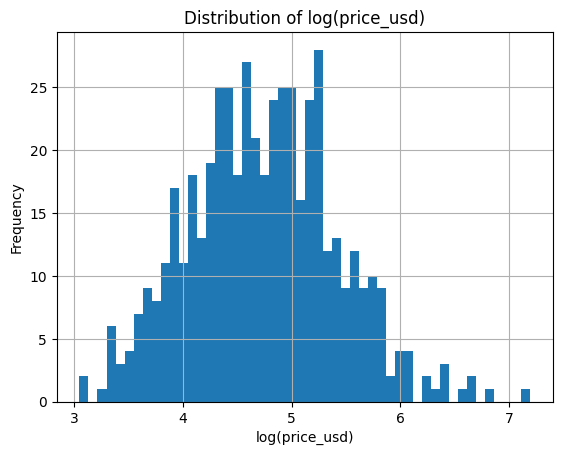

In [5]:
import matplotlib.pyplot as plt

df['price_usd_log'].hist(bins=50)
plt.title("Distribution of log(price_usd)")
plt.xlabel("log(price_usd)")
plt.ylabel("Frequency")
plt.show()


In [6]:
pip install lightgbm scikit-learn pandas


In [7]:
# task3_lambdarank.py

import pandas as pd
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRanker
from sklearn.metrics import ndcg_score
from lightgbm import early_stopping, log_evaluation


# === Load Transformed Data ===
df = pd.read_csv("train_transformed.csv", nrows=200_000)  # Adjust if needed

# === Select Features ===
features = [
    'price_usd_log', 'distance_log', 'prop_location_score1',
    'prop_starrating', 'prop_review_score', 'prop_log_historical_price',
    'srch_length_of_stay', 'srch_booking_window',
    'srch_adults_count', 'srch_children_count',
    'promotion_flag', 'star_diff', 'price_vs_hist',
    'is_null_visitor_hist_adr_usd', 'is_null_visitor_hist_starrating',
    'is_null_prop_review_score', 'is_null_comp1_rate_percent_diff',
    'is_null_orig_destination_distance'
]

X = df[features]
y = df['target']
groups = df['srch_id']

# === Prepare GroupKFold for Group-aware splitting ===
gkf = GroupKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n🧪 Fold {fold+1} training...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    group_train = X_train.groupby(groups.iloc[train_idx]).size().values
    group_val = X_val.groupby(groups.iloc[val_idx]).size().values

    # === Initialize LightGBM Ranker ===
    model = LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    )

    # === Train Model ===
    model.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_at=[5],
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)

    # === Evaluate with NDCG@5 ===
    pred = model.predict(X_val)
    val_df = df.iloc[val_idx].copy()
    val_df['pred'] = pred

    ndcg_vals = []
    for srch_id, group in val_df.groupby('srch_id'):
        if group['target'].sum() == 0:  # avoid all-zero targets
            continue
        y_true = group[['target']].values.T
        y_score = group[['pred']].values.T
        ndcg_vals.append(ndcg_score(y_true, y_score, k=5))

    mean_ndcg = sum(ndcg_vals) / len(ndcg_vals)
    print(f"✅ Fold {fold+1} NDCG@5: {mean_ndcg:.4f}")



🧪 Fold 1 training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 159999, number of used features: 18
Training until validation scores don't improve for 10 rounds
[10]	valid_0's ndcg@5: 0.280078
[20]	valid_0's ndcg@5: 0.274034
Early stopping, best iteration is:
[10]	valid_0's ndcg@5: 0.280078
✅ Fold 1 NDCG@5: 0.2811

🧪 Fold 2 training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 159999, number of used features: 18
Training until validation scores

In [8]:
import pandas as pd
import numpy as np

def enrich_features(df):
    # --- Ranks within each search ---
    df['price_rank_pct'] = df.groupby('srch_id')['price_usd'].rank(pct=True)
    df['score1_rank_pct'] = df.groupby('srch_id')['prop_location_score1'].rank(pct=True)
    df['review_score_rank_pct'] = df.groupby('srch_id')['prop_review_score'].rank(pct=True)

    # --- Deltas from srch_id group means ---
    df['price_vs_group_mean'] = df['price_usd'] - df.groupby('srch_id')['price_usd'].transform('mean')
    df['score1_vs_group_mean'] = df['prop_location_score1'] - df.groupby('srch_id')['prop_location_score1'].transform('mean')
    df['review_vs_group_mean'] = df['prop_review_score'] - df.groupby('srch_id')['prop_review_score'].transform('mean')

    # --- Price Bucket ---
    df['price_bucket'] = pd.cut(df['price_usd_log'], bins=[-np.inf, 4.5, 5.5, np.inf], labels=['low', 'medium', 'high'])

    # --- Star Rating Bucket ---
    df['star_rating_bucket'] = pd.cut(df['prop_starrating'], bins=[0, 2, 3.5, 5], labels=['economy', 'standard', 'premium'])

    # --- Day of Week & One-hot ---
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['day_of_week'] = df['date_time'].dt.dayofweek
    day_dummies = pd.get_dummies(df['day_of_week'], prefix='dow')
    df = pd.concat([df, day_dummies], axis=1)

    return df

# === Property-level CTR + Booking Rate (precompute ONCE) ===
base = pd.read_csv("train_transformed.csv", usecols=['prop_id', 'click_bool', 'booking_bool'])
prop_stats = base.groupby('prop_id').agg({
    'click_bool': 'mean',
    'booking_bool': 'mean'
}).rename(columns={
    'click_bool': 'prop_ctr',
    'booking_bool': 'prop_booking_rate'
}).reset_index()
del base

# === Chunked Processing and Saving ===
chunksize = 500_000
reader = pd.read_csv("train_transformed.csv", chunksize=chunksize)
first = True

for i, chunk in enumerate(reader):
    chunk = chunk.merge(prop_stats, on='prop_id', how='left')
    chunk = enrich_features(chunk)

    out_mode = 'w' if first else 'a'
    header = first
    chunk.to_csv("train_enriched.csv", mode=out_mode, index=False, header=header)
    first = False
    print(f"✅ Chunk {i+1} saved.")


✅ Chunk 1 saved.
✅ Chunk 2 saved.
✅ Chunk 3 saved.
✅ Chunk 4 saved.
✅ Chunk 5 saved.
✅ Chunk 6 saved.
✅ Chunk 7 saved.
✅ Chunk 8 saved.
✅ Chunk 9 saved.
✅ Chunk 10 saved.


In [9]:
import pandas as pd
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRanker
from lightgbm import early_stopping, log_evaluation

# === Load Data ===
df = pd.read_csv("train_enriched.csv", nrows=400_000)  # Adjust as needed

# === Define Feature Columns ===
feature_cols = [
    'price_usd_log', 'distance_log', 'prop_location_score1',
    'prop_starrating', 'prop_review_score', 'prop_log_historical_price',
    'srch_length_of_stay', 'srch_booking_window',
    'srch_adults_count', 'srch_children_count',
    'promotion_flag', 'star_diff', 'price_vs_hist',
    'is_null_visitor_hist_adr_usd', 'is_null_visitor_hist_starrating',
    'is_null_prop_review_score', 'is_null_comp1_rate_percent_diff',
    'is_null_orig_destination_distance',
    'price_rank_pct', 'score1_rank_pct', 'review_score_rank_pct',
    'price_vs_group_mean', 'score1_vs_group_mean', 'review_vs_group_mean',
    'prop_ctr', 'prop_booking_rate'
]

# Add categoricals (LightGBM handles these natively)
cat_cols = ['price_bucket', 'star_rating_bucket']
feature_cols += cat_cols

# === Prepare Inputs ===
X = df[feature_cols]
y = df['target']
groups = df['srch_id']

# === Encode categoricals (as category dtype for LightGBM) ===
X[cat_cols] = X[cat_cols].astype('category')

# === GroupKFold CV ===
gkf = GroupKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n🧪 Fold {fold+1} training...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    group_train = X_train.groupby(groups.iloc[train_idx]).size().values
    group_val = X_val.groupby(groups.iloc[val_idx]).size().values

    model = LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        learning_rate=0.05,
        n_estimators=300,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        group=group_train,
        eval_set=[(X_val, y_val)],
        eval_group=[group_val],
        eval_at=[5],
        callbacks=[
            early_stopping(stopping_rounds=15),
            log_evaluation(period=10)
        ]
    )

    print(f"✅ Fold {fold+1} done.")


<ipython-input-9-d08ee7d5dd2c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].astype('category')



🧪 Fold 1 training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3794
[LightGBM] [Info] Number of data points in the train set: 319996, number of used features: 28
Training until validation scores don't improve for 15 rounds
[10]	valid_0's ndcg@5: 0.395299
[20]	valid_0's ndcg@5: 0.399812
[30]	valid_0's ndcg@5: 0.403024
[40]	valid_0's ndcg@5: 0.401661
[50]	valid_0's ndcg@5: 0.403408
[60]	valid_0's ndcg@5: 0.403645
Early stopping, best iteration is:
[52]	valid_0's ndcg@5: 0.405517
✅ Fold 1 done.

🧪 Fold 2 training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3794
[LightG

In [10]:
import joblib
joblib.dump(model, "lightgbm_model.joblib")


['lightgbm_model.joblib']

In [11]:
import joblib
model = joblib.load("lightgbm_model.joblib")


In [12]:
import pandas as pd
import numpy as np
import joblib

# === Load the trained LightGBM model ===
model = joblib.load("lightgbm_model.joblib")

# === Load prop-level CTR & booking rate ===
prop_stats = pd.read_csv("train_enriched.csv", usecols=['prop_id', 'prop_ctr', 'prop_booking_rate']).drop_duplicates('prop_id')

# === Full list of 28 training features ===
features = [
    'price_usd_log', 'distance_log', 'prop_location_score1',
    'prop_starrating', 'prop_review_score', 'prop_log_historical_price',
    'srch_length_of_stay', 'srch_booking_window',
    'srch_adults_count', 'srch_children_count',
    'promotion_flag', 'star_diff', 'price_vs_hist',
    'is_null_visitor_hist_adr_usd', 'is_null_visitor_hist_starrating',
    'is_null_prop_review_score', 'is_null_comp1_rate_percent_diff',
    'is_null_orig_destination_distance',
    'price_rank_pct', 'score1_rank_pct', 'review_score_rank_pct',
    'price_vs_group_mean', 'score1_vs_group_mean', 'review_vs_group_mean',
    'prop_ctr', 'prop_booking_rate',
    'price_bucket', 'star_rating_bucket'
]

cat_cols = ['price_bucket', 'star_rating_bucket']

# === Transformation Function for Each Chunk ===
def prepare_test(df, prop_stats):
    df['visitor_hist_adr_usd'] = df['visitor_hist_adr_usd'].fillna(-1)
    df['visitor_hist_starrating'] = df['visitor_hist_starrating'].fillna(-1)
    df['prop_review_score'] = df['prop_review_score'].fillna(df['prop_review_score'].median())
    df['orig_destination_distance'] = df['orig_destination_distance'].fillna(df['orig_destination_distance'].median())
    df['comp1_rate_percent_diff'] = df['comp1_rate_percent_diff'].fillna(-999)

    for col in ['visitor_hist_adr_usd', 'visitor_hist_starrating', 'prop_review_score', 'comp1_rate_percent_diff', 'orig_destination_distance']:
        df[f'is_null_{col}'] = df[col].isnull().astype(int)

    df['price_usd_log'] = np.log1p(df['price_usd'])
    df['distance_log'] = np.log1p(df['orig_destination_distance'])
    df['price_vs_hist'] = df['price_usd'] - df['visitor_hist_adr_usd']
    df['star_diff'] = df['prop_starrating'] - df['visitor_hist_starrating']

    df['price_rank_pct'] = df.groupby('srch_id')['price_usd'].rank(pct=True)
    df['score1_rank_pct'] = df.groupby('srch_id')['prop_location_score1'].rank(pct=True)
    df['review_score_rank_pct'] = df.groupby('srch_id')['prop_review_score'].rank(pct=True)
    df['price_vs_group_mean'] = df['price_usd'] - df.groupby('srch_id')['price_usd'].transform('mean')
    df['score1_vs_group_mean'] = df['prop_location_score1'] - df.groupby('srch_id')['prop_location_score1'].transform('mean')
    df['review_vs_group_mean'] = df['prop_review_score'] - df.groupby('srch_id')['prop_review_score'].transform('mean')

    df['price_bucket'] = pd.cut(df['price_usd_log'], [-np.inf, 4.5, 5.5, np.inf], labels=['low', 'medium', 'high'])
    df['star_rating_bucket'] = pd.cut(df['prop_starrating'], [0, 2, 3.5, 5], labels=['economy', 'standard', 'premium'])

    df['date_time'] = pd.to_datetime(df['date_time'])
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df = df.merge(prop_stats, on='prop_id', how='left')

    df[cat_cols] = df[cat_cols].astype('category')
    return df

# === Chunked Prediction ===
chunksize = 100_000
reader = pd.read_csv("/content/data/test_set_VU_DM.csv", chunksize=chunksize)
submission_parts = []

for i, chunk in enumerate(reader):
    print(f"🔄 Processing chunk {i+1}...")
    chunk = prepare_test(chunk, prop_stats)

    # Ensure all 28 features exist (fill if missing due to dummies)
    for col in features:
        if col not in chunk.columns:
            chunk[col] = 0

    # Save ID columns before narrowing the feature list
    chunk_ids = chunk[['srch_id', 'prop_id']].copy()

    # Prepare only model features
    chunk_model_input = chunk[features]
    chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')

    # Predict scores
    chunk_ids['score'] = model.predict(chunk_model_input)

    sorted_chunk = chunk_ids.sort_values(['srch_id', 'score'], ascending=[True, False])[['srch_id', 'prop_id']]
    submission_parts.append(sorted_chunk)

# === Final submission
submission = pd.concat(submission_parts, ignore_index=True)
submission.to_csv("submission.csv", index=False)
print("✅ Submission saved as submission.csv")


🔄 Processing chunk 1...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 2...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 3...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 4...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 5...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 6...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 7...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 8...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 9...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 10...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 11...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 12...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 13...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 14...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 15...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 16...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 17...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 18...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 19...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 20...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 21...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 22...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 23...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 24...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 25...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 26...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 27...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 28...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 29...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 30...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 31...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 32...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 33...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 34...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 35...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 36...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 37...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 38...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 39...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 40...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 41...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 42...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 43...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 44...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 45...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 46...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 47...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 48...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 49...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


🔄 Processing chunk 50...


<ipython-input-12-a20203f7982e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_model_input[cat_cols] = chunk_model_input[cat_cols].astype('category')


✅ Submission saved as submission.csv


In [13]:
df = pd.read_csv("submission.csv")
# Should show True if sorted properly
check = df.groupby('srch_id').cumcount().eq(0).all()
print("✅ Each srch_id starts with top-ranked prop_id:", check)


✅ Each srch_id starts with top-ranked prop_id: False


In [14]:
import pandas as pd
import numpy as np
import joblib

# === Load trained model and property-level stats ===
model = joblib.load("lightgbm_model.joblib")
prop_stats = pd.read_csv("train_enriched.csv", usecols=['prop_id', 'prop_ctr', 'prop_booking_rate']).drop_duplicates('prop_id')

# === Feature list used during training (28 total) ===
features = [
    'price_usd_log', 'distance_log', 'prop_location_score1',
    'prop_starrating', 'prop_review_score', 'prop_log_historical_price',
    'srch_length_of_stay', 'srch_booking_window',
    'srch_adults_count', 'srch_children_count',
    'promotion_flag', 'star_diff', 'price_vs_hist',
    'is_null_visitor_hist_adr_usd', 'is_null_visitor_hist_starrating',
    'is_null_prop_review_score', 'is_null_comp1_rate_percent_diff',
    'is_null_orig_destination_distance',
    'price_rank_pct', 'score1_rank_pct', 'review_score_rank_pct',
    'price_vs_group_mean', 'score1_vs_group_mean', 'review_vs_group_mean',
    'prop_ctr', 'prop_booking_rate',
    'price_bucket', 'star_rating_bucket'
]
cat_cols = ['price_bucket', 'star_rating_bucket']

# === Preprocessing function applied to each chunk ===
def prepare_test(df, prop_stats):
    df['visitor_hist_adr_usd'] = df['visitor_hist_adr_usd'].fillna(-1)
    df['visitor_hist_starrating'] = df['visitor_hist_starrating'].fillna(-1)
    df['prop_review_score'] = df['prop_review_score'].fillna(df['prop_review_score'].median())
    df['orig_destination_distance'] = df['orig_destination_distance'].fillna(df['orig_destination_distance'].median())
    df['comp1_rate_percent_diff'] = df['comp1_rate_percent_diff'].fillna(-999)

    for col in ['visitor_hist_adr_usd', 'visitor_hist_starrating', 'prop_review_score', 'comp1_rate_percent_diff', 'orig_destination_distance']:
        df[f'is_null_{col}'] = df[col].isnull().astype(int)

    df['price_usd_log'] = np.log1p(df['price_usd'])
    df['distance_log'] = np.log1p(df['orig_destination_distance'])
    df['price_vs_hist'] = df['price_usd'] - df['visitor_hist_adr_usd']
    df['star_diff'] = df['prop_starrating'] - df['visitor_hist_starrating']

    df['price_rank_pct'] = df.groupby('srch_id')['price_usd'].rank(pct=True)
    df['score1_rank_pct'] = df.groupby('srch_id')['prop_location_score1'].rank(pct=True)
    df['review_score_rank_pct'] = df.groupby('srch_id')['prop_review_score'].rank(pct=True)
    df['price_vs_group_mean'] = df['price_usd'] - df.groupby('srch_id')['price_usd'].transform('mean')
    df['score1_vs_group_mean'] = df['prop_location_score1'] - df.groupby('srch_id')['prop_location_score1'].transform('mean')
    df['review_vs_group_mean'] = df['prop_review_score'] - df.groupby('srch_id')['prop_review_score'].transform('mean')

    df['price_bucket'] = pd.cut(df['price_usd_log'], [-np.inf, 4.5, 5.5, np.inf], labels=['low', 'medium', 'high'])
    df['star_rating_bucket'] = pd.cut(df['prop_starrating'], [0, 2, 3.5, 5], labels=['economy', 'standard', 'premium'])
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['day_of_week'] = df['date_time'].dt.dayofweek

    df = df.merge(prop_stats, on='prop_id', how='left')
    df[cat_cols] = df[cat_cols].astype('category')

    return df

# === Process test file in chunks and predict scores ===
submission_parts = []
chunksize = 100_000
reader = pd.read_csv("/content/data/test_set_VU_DM.csv", chunksize=chunksize)

for i, chunk in enumerate(reader):
    print(f"🔄 Processing chunk {i+1}...")
    chunk = prepare_test(chunk, prop_stats)

    # Align columns
    for col in features:
        if col not in chunk.columns:
            chunk[col] = 0

    # Save original IDs
    chunk_ids = chunk[['srch_id', 'prop_id']].copy()

    # Predict
    chunk_model_input = chunk[features]
    chunk_model_input.loc[:, cat_cols] = chunk_model_input[cat_cols].astype('category')
    chunk_ids['score'] = model.predict(chunk_model_input)

    # Append for later global sort
    submission_parts.append(chunk_ids)

# === Combine and globally sort
submission = pd.concat(submission_parts, ignore_index=True)

# Sort each srch_id group by score descending
submission = (
    submission
    .sort_values(['srch_id', 'score'], ascending=[True, False])
    .reset_index(drop=True)
)

# Final check before dropping score
check = submission.groupby('srch_id')['score'].apply(lambda x: x.iloc[0] == x.max()).all()
print("✅ Each srch_id top row has highest score:", check)

# Now safely drop score and save
submission = submission[['srch_id', 'prop_id']]
submission.to_csv("submission.csv", index=False)
print("📦 Cleaned submission.csv saved.")


🔄 Processing chunk 1...
🔄 Processing chunk 2...
🔄 Processing chunk 3...
🔄 Processing chunk 4...
🔄 Processing chunk 5...
🔄 Processing chunk 6...
🔄 Processing chunk 7...
🔄 Processing chunk 8...
🔄 Processing chunk 9...
🔄 Processing chunk 10...
🔄 Processing chunk 11...
🔄 Processing chunk 12...
🔄 Processing chunk 13...
🔄 Processing chunk 14...
🔄 Processing chunk 15...
🔄 Processing chunk 16...
🔄 Processing chunk 17...
🔄 Processing chunk 18...
🔄 Processing chunk 19...
🔄 Processing chunk 20...
🔄 Processing chunk 21...
🔄 Processing chunk 22...
🔄 Processing chunk 23...
🔄 Processing chunk 24...
🔄 Processing chunk 25...
🔄 Processing chunk 26...
🔄 Processing chunk 27...
🔄 Processing chunk 28...
🔄 Processing chunk 29...
🔄 Processing chunk 30...
🔄 Processing chunk 31...
🔄 Processing chunk 32...
🔄 Processing chunk 33...
🔄 Processing chunk 34...
🔄 Processing chunk 35...
🔄 Processing chunk 36...
🔄 Processing chunk 37...
🔄 Processing chunk 38...
🔄 Processing chunk 39...
🔄 Processing chunk 40...
🔄 Process